In [22]:
from data import cifar10, swiss_roll_data, get_word2vec_data, plot_swiss_roll, word_embedding_plot, cifar10_latent_plot
from model import VAE
from train import train_vae, train_resnet18
import torch
import torchvision
import numpy as np
import gensim
import matplotlib.pyplot as plt
import time

## Swiss Roll

In [23]:
nr_samples = 5000
data_loader, data, time = swiss_roll_data(split=[nr_samples, 1500, 1500], batch_size=nr_samples)
train_loader, val_loader, test_loader = data_loader
train_data, val_data, test_data = data 
train_time, val_time, test_time = time

100%|██████████| 120/120 [00:05<00:00, 22.47it/s]


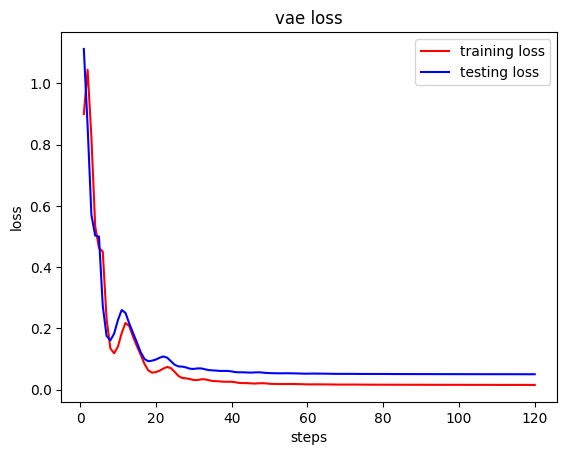

In [24]:
vae = VAE(input_dimension=3, hidden_dims=200, latent_dims=2)
train_vae(120, vae, train_loader, test_loader, lr=0.001)

In [25]:
start_time = time.time()
latent_data = vae.encoder(train_data).detach().numpy()
plot_swiss_roll(nr_samples, train_data, train_time, latent_data)
print("VAE analysis performed in %s seconds." % (time.time() - start_time))

AttributeError: 'list' object has no attribute 'time'

## Word2vec

In [11]:
# this may takes 1 min.
nr_samples = 5000
loader, embedding, words, gensim_model = get_word2vec_data(split=[nr_samples, 1000, 1000], seed=3407, batch_size=32)
train_loader, val_loader, test_loader = loader
train_embeddings, val_embeddings, test_embeddings = embedding
train_words, val_words, test_words = words

C:\Users\Time_Zephyrus/gensim-data


100%|██████████| 100/100 [01:34<00:00,  1.06it/s]


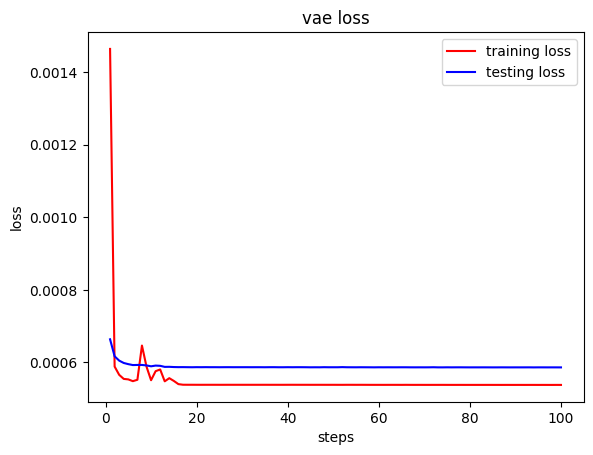

In [12]:
vae = VAE(input_dimension=300, hidden_dims=256, latent_dims=2)
train_vae(100, vae, train_loader, test_loader, lr=0.001)

In [13]:
torch.save(vae, './weights/word2vec_vae.pt')

China Beijing
Russia Moscow
Japan Tokyo
Turkey Ankara
Poland Warsaw
Germany Berlin
France Paris
Italy Athens
Greece Rome
Spain Madrid
Portugal Lisbon


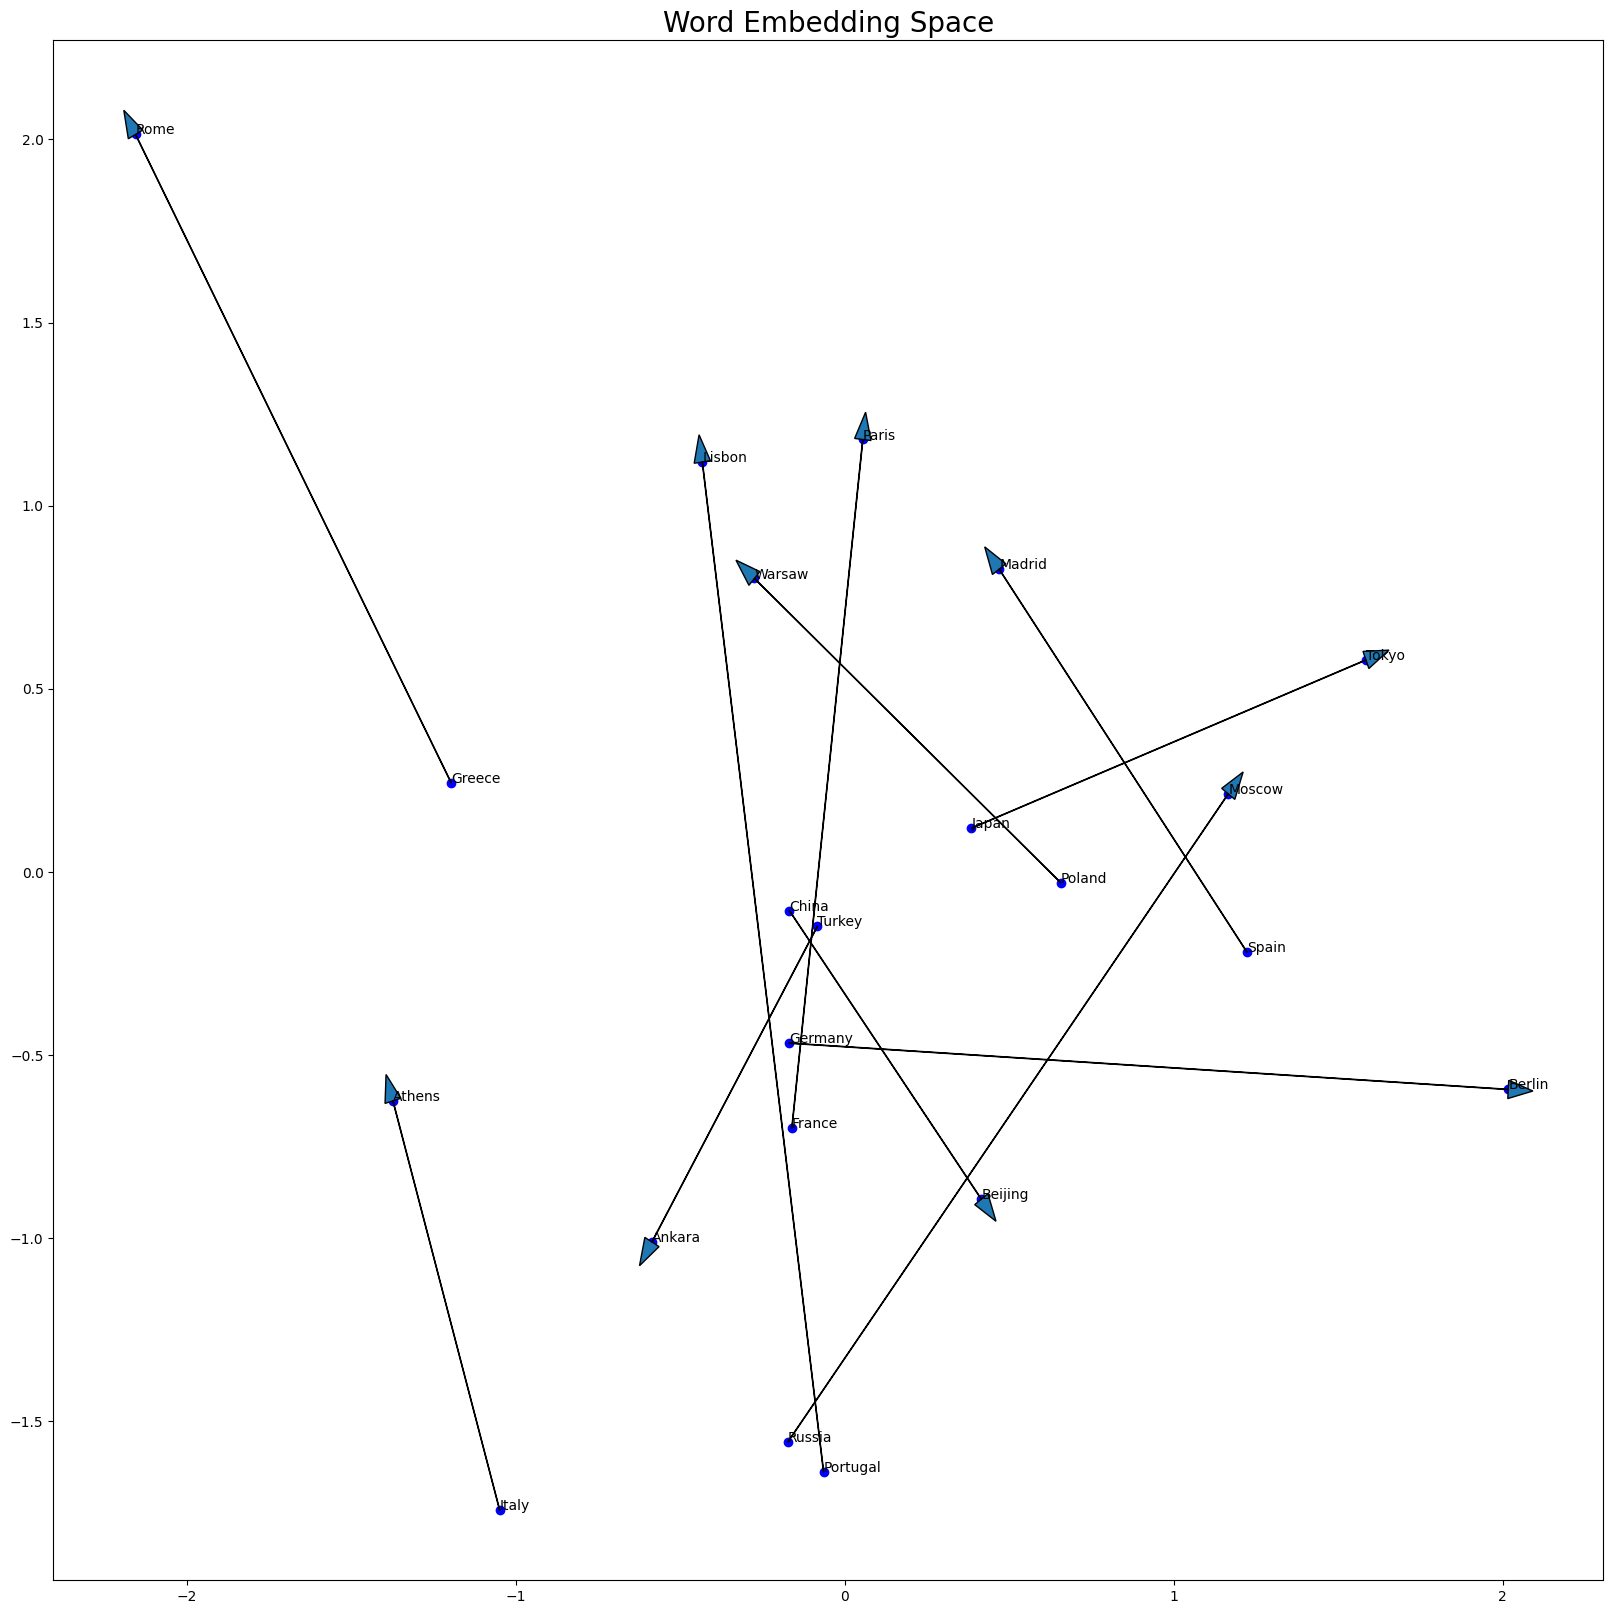

In [14]:
countries = ['China', 'Russia', 'Japan', 'Turkey', 'Poland', 'Germany', 'France', 'Italy', 'Greece', 'Spain', 'Portugal']
capitals = ['Beijing', 'Moscow', 'Tokyo', 'Ankara', 'Warsaw', 'Berlin', 'Paris', 'Athens', 'Rome', 'Madrid', 'Lisbon']
embeddings = [gensim_model[word] for word in countries + capitals]
embeddings = np.array(embeddings)
embeddings = torch.tensor(embeddings)

dim_red_em = vae.encoder(embeddings).detach().numpy()

word_embedding_plot(dim_red_em, countries + capitals)
# plt.arrow(dim_red_em[0, 0], dim_red_em[0, 1], dim_red_em[0, 0]-dim_red_em[0, 0], dim_red_em[0, 1]-dim_red_em[0, 1], head_width = 0.05)
for i in range(len(countries)):
    country = dim_red_em[i]
    capital = dim_red_em[i+len(countries)]
    print(countries[i], capitals[i])
    plt.arrow(country[0], country[1], capital[0]-country[0], capital[1]-country[1], head_width = 0.05)

## Cifar 10

In [15]:
train_loader, val_loader, test_loader = cifar10(train_val_split = [45000, 5000], batch_size=32)

Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 10/10 [09:26<00:00, 56.63s/it]


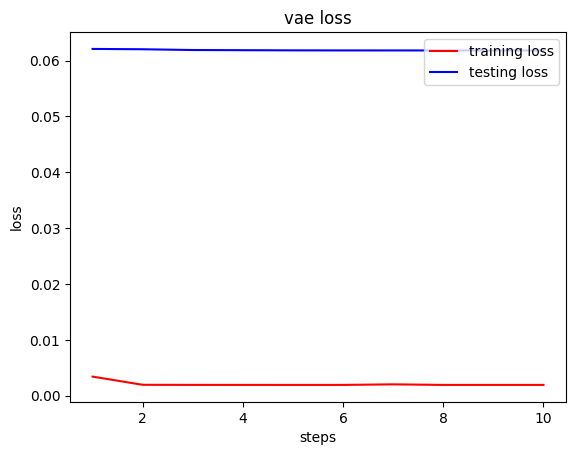

In [16]:
epochs = 10

vae = VAE(input_dimension=32*32*3, hidden_dims=256, latent_dims=2)
train_vae(epochs, vae, train_loader, test_loader, lr=0.001, is_cifar=True)

In [17]:
torch.save(vae, './weights/cifar10_vae.pt')

In [18]:
vae = torch.load('./weights/cifar10_vae.pt')

In [19]:
latent = torch.tensor([])
y_ = torch.tensor([])
for (x, y) in train_loader:
    x = x.reshape((len(x), -1))
    z = vae.encoder(x)
    latent = torch.concat([latent, z], dim=0)
    y_ = torch.concat([y_, y], dim=0)
latent = latent.detach().numpy()
y_ = y_.detach().numpy()

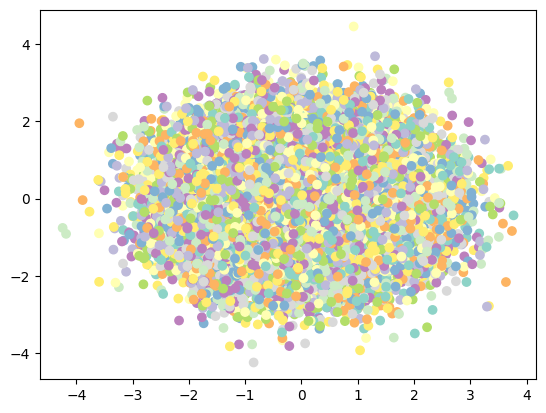

In [20]:
cifar10_latent_plot(latent, y_)

## performance

In [ ]:
model = torchvision.models.resnet18(False)
model.fc = torch.nn.Linear(512, 10)
opt = torch.optim.Adam(model.parameters(), lr=0.001)
train_resnet18(epochs, train_loader, batch_size=32)

e:\Anaconda\envs\cms\lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
e:\Anaconda\envs\cms\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


TypeError: train_resnet18() missing 3 required positional arguments: 'opt', 'train_loader', and 'val_loader'